# Prediccion - PASCAL VOC 2007 Multilabel

## Objetivo
Cargar el modelo y realizar predicciones multilabel REALES sobre objetos.

Ejemplos: persona + carro + perro, etc.

---
## 1. Importación de Librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from PIL import Image
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

print(f" TensorFlow version: {tf.__version__}")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

 TensorFlow version: 2.20.0


---
## 2. Configuración y Rutas

In [3]:
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / 'data' / 'voc2007'
MODELS_DIR = PROJECT_ROOT / 'models'
TEST_IMAGES_DIR = PROJECT_ROOT / 'data' / 'test_images'
TEST_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
DEFAULT_THRESHOLD = 0.5

print(f"Configuracion para PASCAL VOC 2007")
print(f"Datos: {DATA_DIR}")
print(f"Modelos: {MODELS_DIR}")
print(f"Test images: {TEST_IMAGES_DIR}")

Configuracion para PASCAL VOC 2007
Datos: c:\Users\mlata\Documents\iajordy2\data\voc2007
Modelos: c:\Users\mlata\Documents\iajordy2\models
Test images: c:\Users\mlata\Documents\iajordy2\data\test_images


---
## 3. Cargar Modelo Entrenado

In [5]:
# Definir loss personalizada para carga del modelo
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Focal Loss para multilabel (debe coincidir con el entrenamiento).
    """
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_weight = tf.pow(1 - p_t, gamma)
    focal_bce = focal_weight * bce
    return tf.reduce_mean(focal_bce)

# Cargar modelo final con custom_objects
preferred_model = MODELS_DIR / 'voc_multilabel_final.h5'
legacy_model = MODELS_DIR / 'food_multilabel_final.h5'

if preferred_model.exists():
    model_path = preferred_model
elif legacy_model.exists():
    model_path = legacy_model
else:
    model_path = preferred_model

if model_path.exists():
    model = keras.models.load_model(
        model_path,
        custom_objects={'focal_loss': focal_loss},
        compile=False  # No compilar, solo cargar pesos
    )
    print(f" Modelo cargado desde: {model_path}")
else:
    print(f" Modelo no encontrado en: {model_path}")
    print("   Ejecuta primero el notebook 03_training_real_images.ipynb")
    raise FileNotFoundError(f"Modelo no encontrado en {model_path}")

# Verificar arquitectura
print(f"\n Información del modelo:")
print(f"   Input shape: {model.input_shape}")
print(f"   Output shape: {model.output_shape}")
print(f"   Número de clases: {model.output_shape[1]}")

 Modelo cargado desde: c:\Users\mlata\Documents\iajordy2\models\voc_multilabel_final.h5

 Información del modelo:
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 20)
   Número de clases: 20


---
## 4. Cargar Clases y Configuración

In [6]:
# Cargar clases
with open(DATA_DIR / 'classes.json', 'r') as f:
    classes = json.load(f)

NUM_CLASSES = len(classes)

print(f"Clases cargadas: {NUM_CLASSES}")
print(f"Ejemplos: {classes[:10]}")

Clases cargadas: 20
Ejemplos: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow']


---
## 5. Función de Preprocesamiento de Imágenes

In [7]:
def preprocess_image(img_input, target_size=(224, 224)):
    """
    Preprocesa imagen desde archivo local, URL o array numpy.
    """
    if isinstance(img_input, str):
        if img_input.startswith('http'):
            # Descargar desde URL
            response = requests.get(img_input, timeout=10)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            # Cargar desde archivo local
            img = Image.open(img_input).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img, dtype=np.float32) / 255.0
    elif isinstance(img_input, np.ndarray):
        if img_input.ndim == 4:
            return img_input
        img = Image.fromarray(img_input.astype('uint8')).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img, dtype=np.float32) / 255.0
    else:
        raise ValueError("img_input debe ser ruta, URL o array numpy")
    
    return np.expand_dims(img_array, axis=0)

print("Funcion de preprocesamiento definida (soporta URLs y archivos locales)")

Funcion de preprocesamiento definida (soporta URLs y archivos locales)


---
## 6. Función de Predicción Multilabel

In [8]:
def predict_multilabel(model, img_input, classes, threshold=0.5, top_k=None):
    """
    Realiza predicción multilabel sobre una imagen.
    
    Args:
        model: Modelo de Keras entrenado
        img_input: Ruta a imagen o array preprocesado
        classes: Lista de nombres de clases
        threshold: Umbral de probabilidad para considerar una clase
        top_k: Número máximo de clases a devolver (None = todas)
    
    Returns:
        Dict con labels, probabilidades y predicción binaria
    """
    # Preprocesar si es necesario
    if not isinstance(img_input, np.ndarray) or img_input.ndim != 4:
        img_array = preprocess_image(img_input)
    else:
        img_array = img_input
    
    # Predicción (probabilidades sigmoid)
    predictions = model.predict(img_array, verbose=0)[0]
    
    # Aplicar threshold
    binary_predictions = (predictions >= threshold).astype(int)
    
    # Obtener índices de clases predichas
    predicted_indices = np.where(binary_predictions == 1)[0]
    
    # Crear lista de resultados
    results = []
    for idx in predicted_indices:
        results.append({
            'class': classes[idx],
            'probability': float(predictions[idx])
        })
    
    # Ordenar por probabilidad (mayor a menor)
    results = sorted(results, key=lambda x: x['probability'], reverse=True)
    
    # Limitar a top_k si se especifica
    if top_k is not None:
        results = results[:top_k]
    
    # También devolver todas las probabilidades para análisis
    all_predictions = [
        {'class': classes[i], 'probability': float(predictions[i])}
        for i in range(len(classes))
    ]
    all_predictions = sorted(all_predictions, key=lambda x: x['probability'], reverse=True)
    
    return {
        'predicted_labels': [r['class'] for r in results],
        'predictions': results,
        'all_predictions': all_predictions,
        'num_labels': len(results),
        'threshold': threshold
    }

print(" Función de predicción definida")

 Función de predicción definida


---
## 7. Función de Visualización de Predicciones

In [9]:
def visualize_prediction(img_input, prediction_result, figsize=(14, 6)):
    """
    Visualiza una imagen con sus predicciones multilabel.
    
    Args:
        img_input: Ruta a la imagen o array
        prediction_result: Resultado de predict_multilabel()
        figsize: Tamaño de la figura
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Cargar imagen para visualización
    if isinstance(img_input, (str, Path)):
        img = Image.open(img_input)
    elif isinstance(img_input, np.ndarray):
        if img_input.ndim == 4:
            img = Image.fromarray(img_input[0].astype('uint8'))
        else:
            img = Image.fromarray(img_input.astype('uint8'))
    
    # Subplot 1: Imagen
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Imagen de Entrada', fontsize=14, fontweight='bold')
    
    # Subplot 2: Predicciones
    predictions = prediction_result['predictions'][:10]  # Top 10
    
    if len(predictions) > 0:
        labels = [p['class'] for p in predictions]
        probs = [p['probability'] for p in predictions]
        
        # Colores: verde para predicho, amarillo para probabilidad media
        colors = ['green' if p >= prediction_result['threshold'] else 'orange' 
                  for p in probs]
        
        y_pos = np.arange(len(labels))
        axes[1].barh(y_pos, probs, color=colors, edgecolor='black')
        axes[1].set_yticks(y_pos)
        axes[1].set_yticklabels(labels)
        axes[1].invert_yaxis()
        axes[1].set_xlabel('Probabilidad', fontsize=12)
        axes[1].set_title('Top Predicciones Multilabel', fontsize=14, fontweight='bold')
        axes[1].axvline(x=prediction_result['threshold'], color='red', 
                        linestyle='--', linewidth=2, label=f"Threshold={prediction_result['threshold']}")
        axes[1].legend()
        axes[1].grid(axis='x', alpha=0.3)
        axes[1].set_xlim([0, 1])
    else:
        axes[1].text(0.5, 0.5, 'No se detectaron etiquetas\ncon el threshold actual', 
                     ha='center', va='center', fontsize=12)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir resumen
    print(f"\n RESULTADO DE PREDICCIÓN\n")
    print(f"{'='*60}")
    print(f"Threshold utilizado: {prediction_result['threshold']}")
    print(f"Número de etiquetas detectadas: {prediction_result['num_labels']}")
    print(f"\n Etiquetas predichas:")
    if prediction_result['num_labels'] > 0:
        for pred in prediction_result['predictions']:
            print(f"   • {pred['class']}: {pred['probability']:.4f} ({pred['probability']*100:.2f}%)")
    else:
        print("   (Ninguna)")
    print(f"{'='*60}")

print(" Función de visualización definida")

 Función de visualización definida


---
## 8. Prediccion con Imagenes de Prueba

Test images preparadas: (10, 224, 224, 3)
Seleccionadas imagenes con multilabel real
Predicciones realizadas


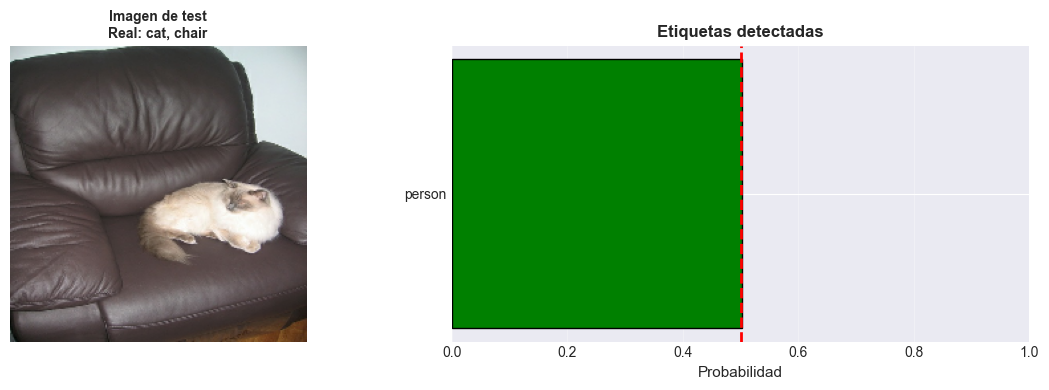

Imagen 1:
  Real: cat, chair
  Predicho: person



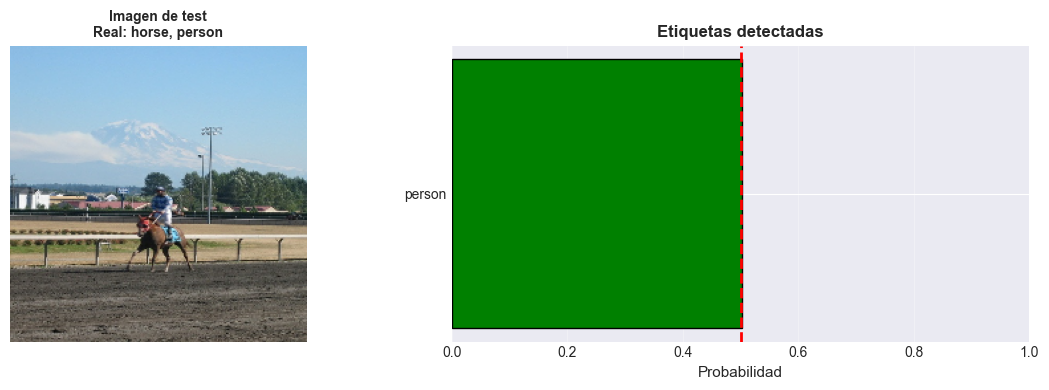

Imagen 2:
  Real: horse, person
  Predicho: person



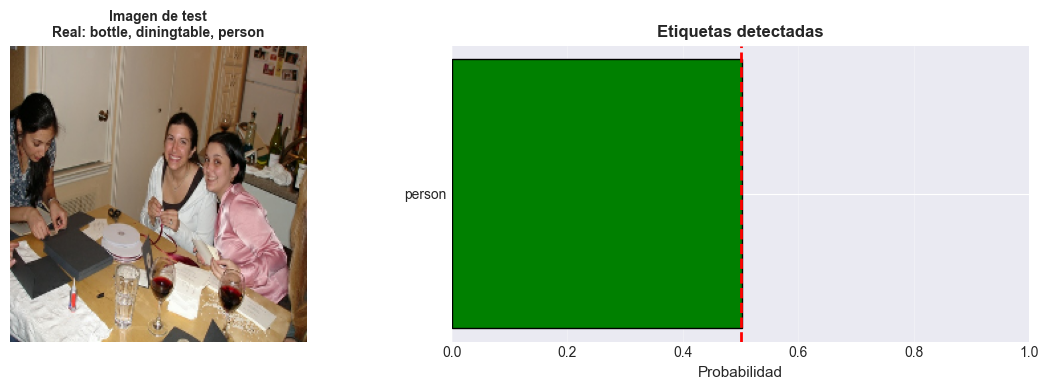

Imagen 3:
  Real: bottle, diningtable, person
  Predicho: person



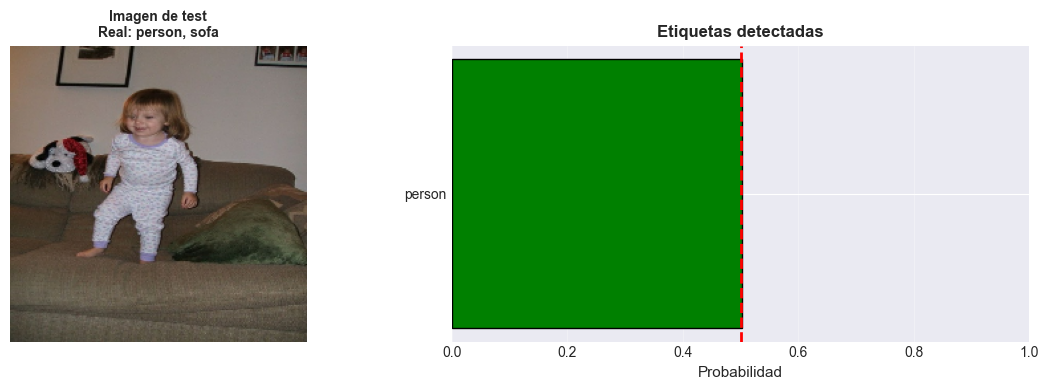

Imagen 4:
  Real: person, sofa
  Predicho: person



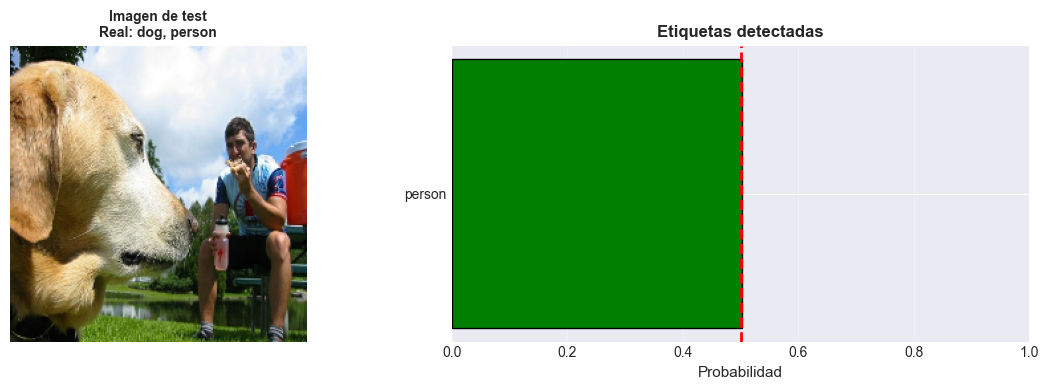

Imagen 5:
  Real: dog, person
  Predicho: person



In [10]:
# Cargar imagenes de test desde PASCAL VOC (NPZ)
npz_file = DATA_DIR / 'voc2007_multilabel.npz'
if not npz_file.exists():
    raise FileNotFoundError(f"No se encuentra {npz_file}. Ejecuta primero 01_data_analysis.ipynb")

data = np.load(npz_file, allow_pickle=True)
test_images_all = data['images']
test_labels_all = data['labels']

# Tomar imagenes con multiples categorias (multilabel real)
multilabel_mask = test_labels_all.sum(axis=1) >= 2
multilabel_indices = np.where(multilabel_mask)[0]

if len(multilabel_indices) >= 10:
    # Tomar imagenes multilabel
    test_indices = np.random.choice(multilabel_indices, size=10, replace=False)
else:
    # Tomar aleatorias
    test_indices = np.random.choice(len(test_images_all), size=10, replace=False)

test_images = test_images_all[test_indices]
test_labels = test_labels_all[test_indices]

# Normalizar
if test_images.max() > 1.0:
    test_images = test_images.astype(np.float32) / 255.0

print(f"Test images preparadas: {test_images.shape}")
print(f"Seleccionadas imagenes con multilabel real")

# Realizar predicciones
y_pred_probs = model.predict(test_images, verbose=0)

print(f"Predicciones realizadas")

# Visualizar resultados
for i in range(min(5, len(test_images))):
    pred_threshold = y_pred_probs[i] >= DEFAULT_THRESHOLD
    pred_labels = np.where(pred_threshold)[0]
    pred_label_names = [classes[idx] for idx in pred_labels]
    pred_probs = y_pred_probs[i][pred_threshold]
    
    # Etiquetas verdaderas
    true_labels = np.where(test_labels[i] == 1)[0]
    true_label_names = [classes[idx] for idx in true_labels]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    img = test_images[i]
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title(f'Imagen de test\nReal: {", ".join(true_label_names)}', fontsize=10, fontweight='bold')

    if len(pred_label_names) > 0:
        labels = pred_label_names
        probs = pred_probs
        colors = ['green'] * len(labels)
    else:
        labels = ['(Ninguna)']
        probs = [0]
        colors = ['gray']
    
    axes[1].barh(labels, probs, color=colors, edgecolor='black')
    axes[1].set_xlim([0, 1])
    axes[1].set_xlabel('Probabilidad', fontsize=11)
    axes[1].set_title('Etiquetas detectadas', fontsize=12, fontweight='bold')
    axes[1].axvline(x=DEFAULT_THRESHOLD, color='red', linestyle='--', linewidth=2)
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print(f"Imagen {i+1}:")
    print(f"  Real: {', '.join(true_label_names)}")
    print(f"  Predicho: {', '.join(pred_label_names) if pred_label_names else '(Ninguna)'}")
    print()

---
## 9. Predicción con Diferentes Thresholds

###  Importancia del Threshold:
El threshold determina cuándo una probabilidad se convierte en una predicción positiva.

- **Threshold bajo (0.3)**: Más etiquetas, mayor recall, menor precisión
- **Threshold medio (0.5)**: Balance entre precisión y recall
- **Threshold alto (0.7)**: Menos etiquetas, mayor precisión, menor recall

In [26]:
# Comparar diferentes thresholds usando la primera imagen de test_images
thresholds = [0.3, 0.5, 0.7]

# Usar la primera imagen del batch de test obtenido antes
sample_image = test_images[0]

print(" Comparación de Thresholds\n")
print("="*80)

threshold_results = {}
for thresh in thresholds:
    result = predict_multilabel(
        model=model,
        img_input=sample_image,
        classes=classes,
        threshold=thresh
    )
    threshold_results[thresh] = result
    
    print(f"\nThreshold: {thresh}")
    print(f"  Etiquetas detectadas: {result['num_labels']}")
    print(f"  Labels: {', '.join(result['predicted_labels'][:5])}...")

print("\n" + "="*80)

 Comparación de Thresholds




Threshold: 0.3
  Etiquetas detectadas: 1
  Labels: rice...

Threshold: 0.5
  Etiquetas detectadas: 0
  Labels: ...

Threshold: 0.7
  Etiquetas detectadas: 0
  Labels: ...



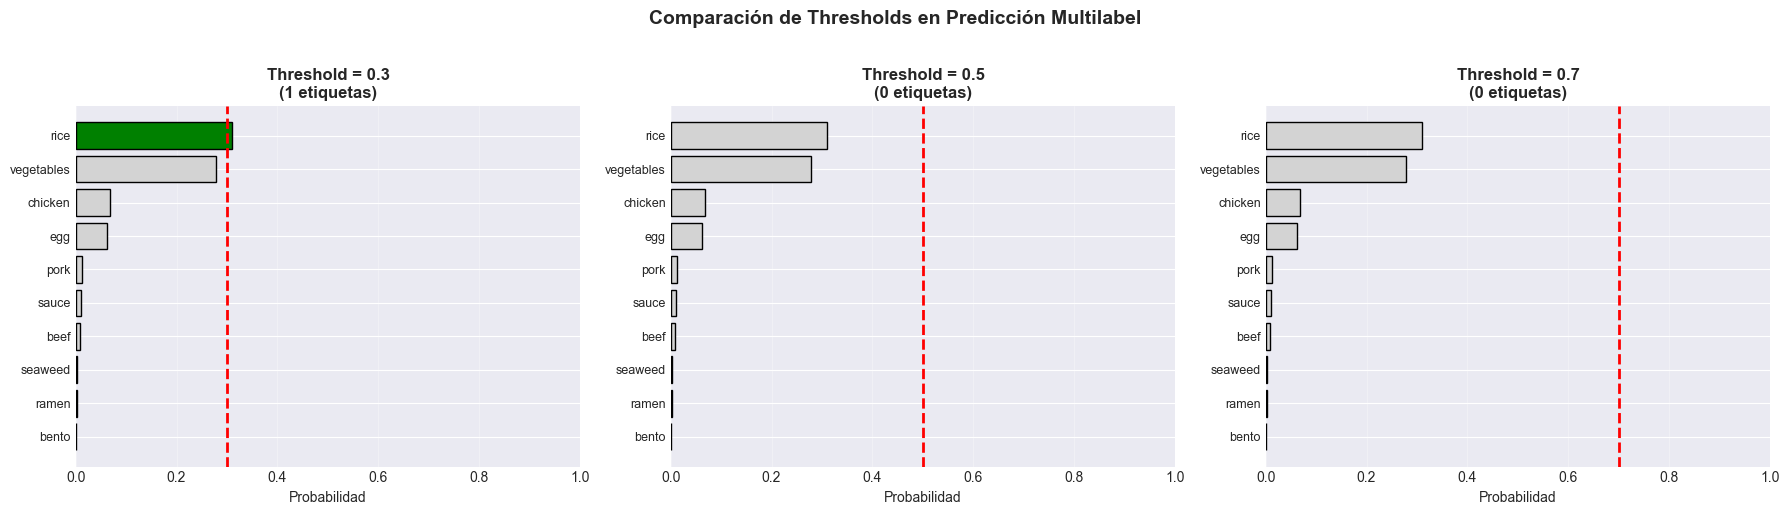

In [27]:
# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, thresh in enumerate(thresholds):
    result = threshold_results[thresh]
    predictions = result['all_predictions'][:10]
    
    labels = [p['class'] for p in predictions]
    probs = [p['probability'] for p in predictions]
    colors = ['green' if p >= thresh else 'lightgray' for p in probs]
    
    y_pos = np.arange(len(labels))
    axes[idx].barh(y_pos, probs, color=colors, edgecolor='black')
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(labels, fontsize=9)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Probabilidad', fontsize=10)
    axes[idx].set_title(f'Threshold = {thresh}\n({result["num_labels"]} etiquetas)', 
                        fontsize=12, fontweight='bold')
    axes[idx].axvline(x=thresh, color='red', linestyle='--', linewidth=2)
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].set_xlim([0, 1])

plt.suptitle('Comparación de Thresholds en Predicción Multilabel', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 10. Predicción en Batch

In [11]:
# Cargar datos de test para predicción en batch
# (En un proyecto real, cargarías imágenes reales)

# Simular batch de imágenes
num_samples = 5
batch_images = np.random.randint(0, 255, (num_samples, *IMG_SIZE, 3), dtype='uint8')

print(f" Realizando predicción en batch de {num_samples} imágenes...\n")

# Predicción en batch
batch_predictions = model.predict(batch_images.astype('float32'), verbose=0)

# Procesar cada imagen
for i, (img, preds) in enumerate(zip(batch_images, batch_predictions)):
    binary_preds = (preds >= 0.5).astype(int)
    predicted_indices = np.where(binary_preds == 1)[0]
    predicted_labels = [classes[idx] for idx in predicted_indices]
    
    print(f"Imagen {i+1}:")
    print(f"  Etiquetas: {', '.join(predicted_labels) if len(predicted_labels) > 0 else 'Ninguna'}")
    print(f"  Número: {len(predicted_labels)}")
    print()

 Realizando predicción en batch de 5 imágenes...

Imagen 1:
  Etiquetas: car, chair, person
  Número: 3

Imagen 2:
  Etiquetas: car, person
  Número: 2

Imagen 3:
  Etiquetas: car, person
  Número: 2

Imagen 4:
  Etiquetas: car, person
  Número: 2

Imagen 5:
  Etiquetas: car, chair, person
  Número: 3



---
## 11. Análisis de Confianza de Predicciones

In [ ]:
# Usar primera imagen del batch de test (si existe)
if 'test_images' in locals() and len(test_images) > 0:
    sample_image = test_images[0]
else:
    # Si no hay test_images, cargar una del NPZ
    npz_file = DATA_DIR / 'voc2007_multilabel.npz'
    data = np.load(npz_file, allow_pickle=True)
    sample_image = data['images'][0].astype(np.float32) / 255.0

# Analizar distribución de probabilidades
result = predict_multilabel(
    model=model,
    img_input=sample_image,
    classes=classes,
    threshold=0.5
)

all_probs = [p['probability'] for p in result['all_predictions']]

# Visualización de distribución
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma de probabilidades
axes[0].hist(all_probs, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0].set_xlabel('Probabilidad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Probabilidades Predichas', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Top 20 clases por probabilidad
top_20 = result['all_predictions'][:20]
labels_top20 = [p['class'] for p in top_20]
probs_top20 = [p['probability'] for p in top_20]
colors_top20 = ['green' if p >= 0.5 else 'orange' for p in probs_top20]

y_pos = np.arange(len(labels_top20))
axes[1].barh(y_pos, probs_top20, color=colors_top20, edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(labels_top20, fontsize=9)
axes[1].invert_yaxis()
axes[1].set_xlabel('Probabilidad', fontsize=12)
axes[1].set_title('Top 20 Clases por Probabilidad', fontsize=14, fontweight='bold')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas
print(f"\n Estadísticas de Probabilidades:\n")
print(f"   Media: {np.mean(all_probs):.4f}")
print(f"   Mediana: {np.median(all_probs):.4f}")
print(f"   Desv. estándar: {np.std(all_probs):.4f}")
print(f"   Máximo: {np.max(all_probs):.4f}")
print(f"   Mínimo: {np.min(all_probs):.4f}")
print(f"\n   Clases > 0.5: {sum(1 for p in all_probs if p >= 0.5)}")
print(f"   Clases > 0.7: {sum(1 for p in all_probs if p >= 0.7)}")
print(f"   Clases > 0.9: {sum(1 for p in all_probs if p >= 0.9)}")

NameError: name 'sample_image' is not defined

---
## 12. Función para Guardar Predicciones

In [30]:
def save_predictions(predictions, output_path):
    """
    Guarda predicciones en formato JSON.
    
    Args:
        predictions: Resultado de predict_multilabel()
        output_path: Ruta donde guardar el archivo
    """
    with open(output_path, 'w') as f:
        json.dump(predictions, f, indent=2)
    print(f" Predicciones guardadas en: {output_path}")

# Ejemplo de uso
output_file = DATA_DIR / 'sample_prediction.json'
save_predictions(result, output_file)

 Predicciones guardadas en: c:\Users\mlata\Documents\iajordy2\data\sample_prediction.json


---
## 13. Ejemplo de Predicción en Imagen Real (Si Disponible)


 Procesando: 1.jpg


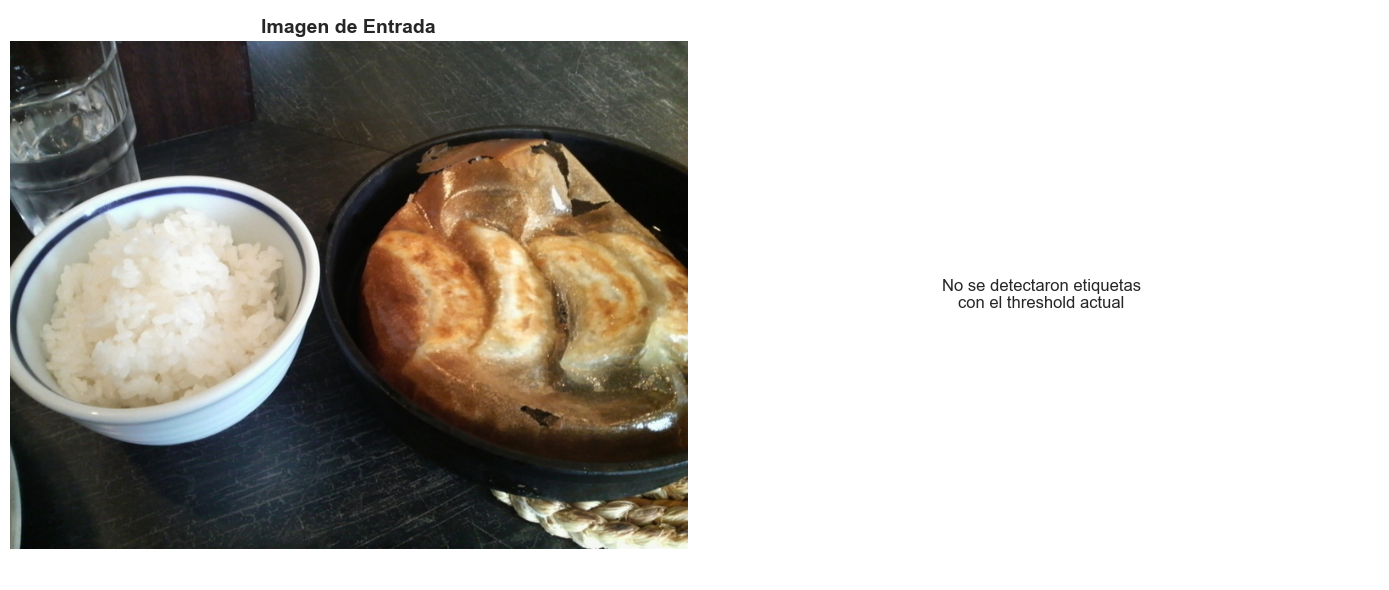


 RESULTADO DE PREDICCIÓN

Threshold utilizado: 0.5
Número de etiquetas detectadas: 0

 Etiquetas predichas:
   (Ninguna)

 Procesando: 10.jpg


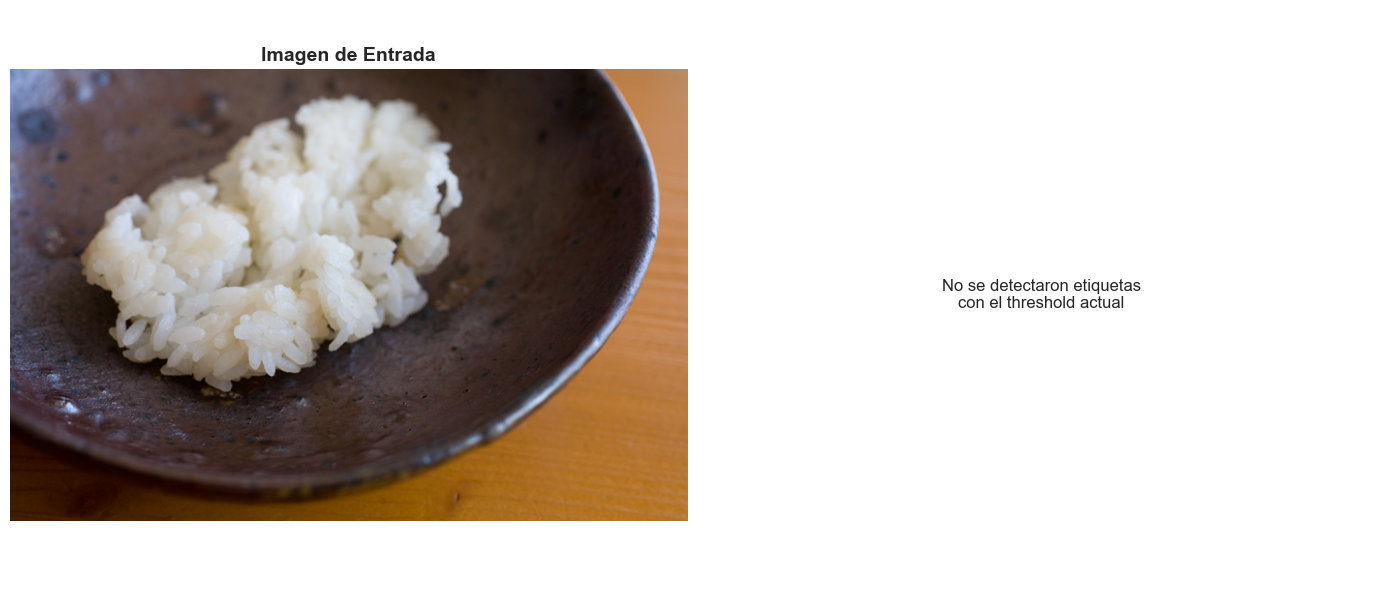


 RESULTADO DE PREDICCIÓN

Threshold utilizado: 0.5
Número de etiquetas detectadas: 0

 Etiquetas predichas:
   (Ninguna)

 Procesando: 10572.jpg


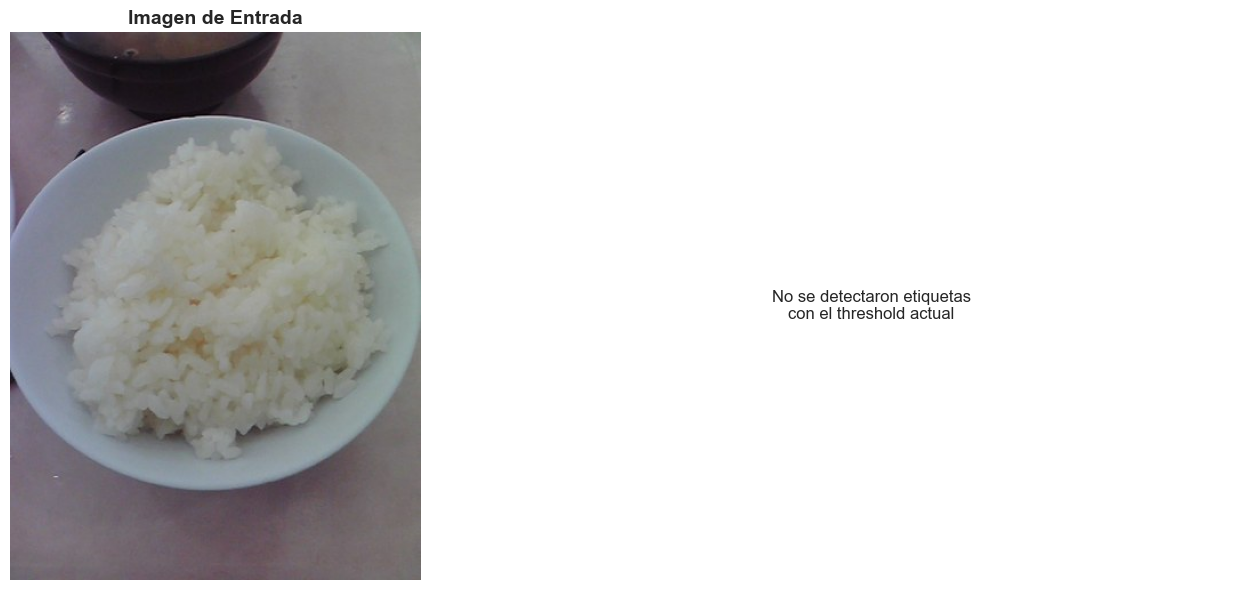


 RESULTADO DE PREDICCIÓN

Threshold utilizado: 0.5
Número de etiquetas detectadas: 0

 Etiquetas predichas:
   (Ninguna)

 Procesando: 10586.jpg


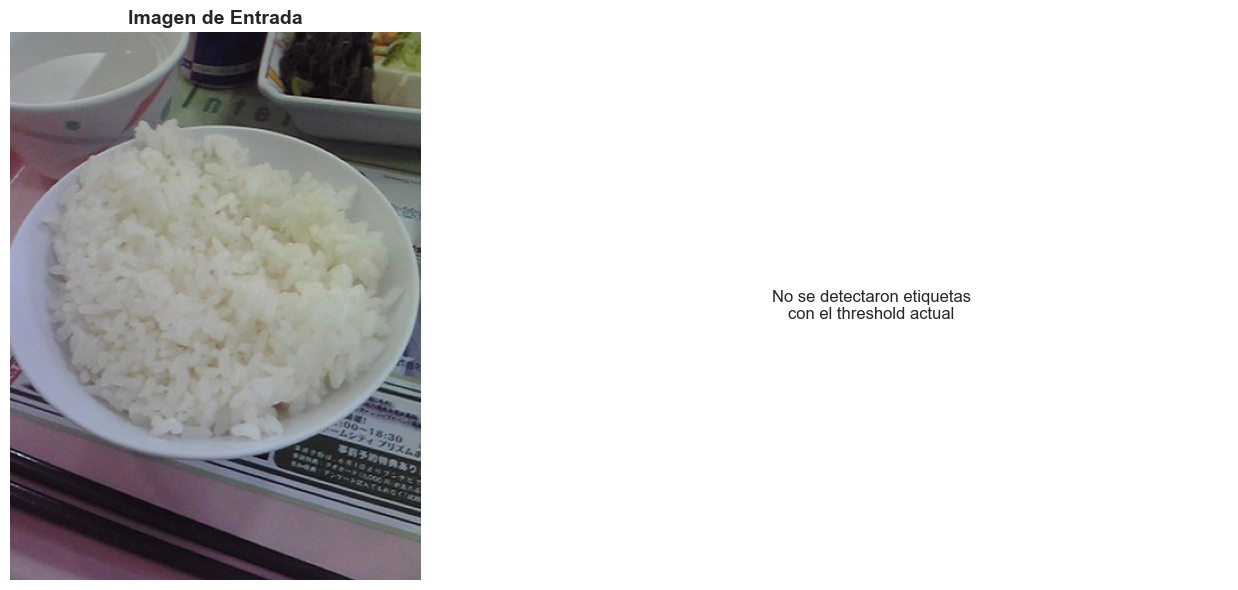


 RESULTADO DE PREDICCIÓN

Threshold utilizado: 0.5
Número de etiquetas detectadas: 0

 Etiquetas predichas:
   (Ninguna)

 Procesando: 10617.jpg


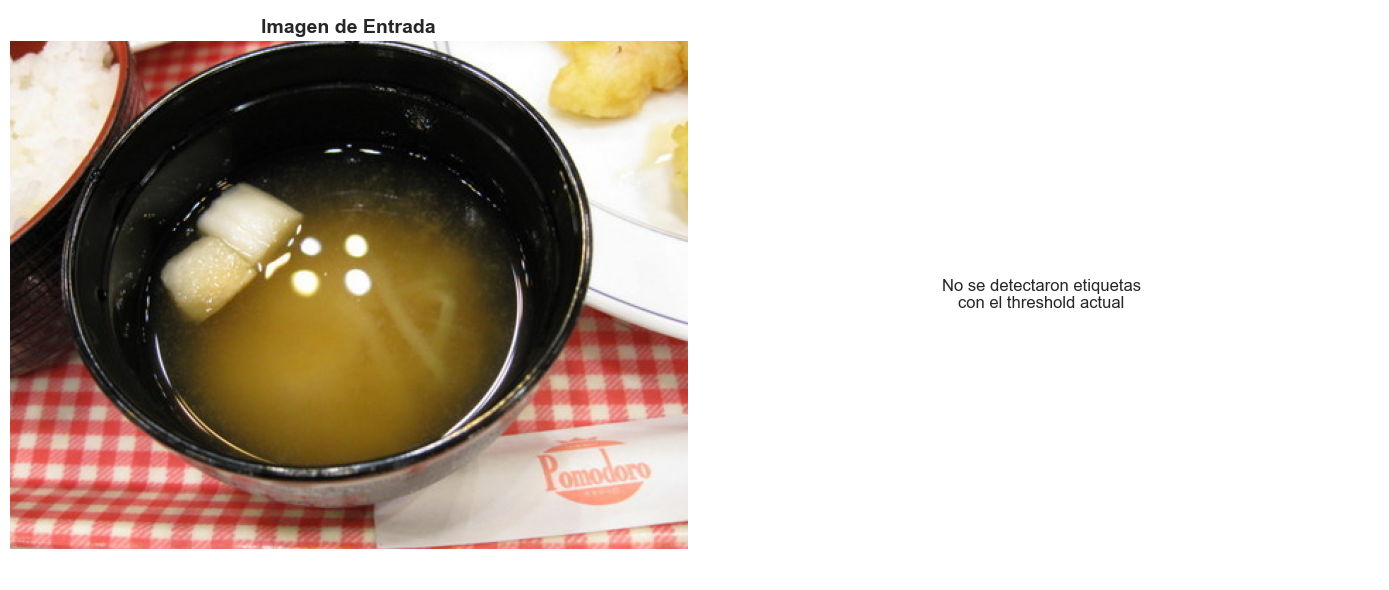


 RESULTADO DE PREDICCIÓN

Threshold utilizado: 0.5
Número de etiquetas detectadas: 0

 Etiquetas predichas:
   (Ninguna)
 Código de ejemplo para imágenes reales disponible (comentado)
   Descomenta el código anterior cuando tengas el dataset UECFood256


In [ ]:
# Prediccion desde imagen local (si existe en test_images)
local_images = list(TEST_IMAGES_DIR.glob('*.jpg')) + list(TEST_IMAGES_DIR.glob('*.png'))

if len(local_images) > 0:
    sample_path = str(local_images[0])
    print(f"Probando prediccion desde archivo local:")
    print(f"  {sample_path}")
    
    try:
        result = predict_multilabel(
            model=model,
            img_input=sample_path,
            classes=classes,
            threshold=0.5,
        )
        
        visualize_prediction(sample_path, result)
    except Exception as e:
        print(f"Error: {e}")
else:
    print("No hay imagenes en data/test_images/. Agrega una imagen .jpg o .png para probar.")

---
## 14. Utilidad: Predicción desde URL o Archivo Local

In [32]:
def predict_from_path(image_path, threshold=0.5, visualize=True):
    """
    Función completa de predicción desde ruta de archivo.
    
    Args:
        image_path: Ruta local a la imagen
        threshold: Umbral de decisión
        visualize: Si True, muestra visualización
    
    Returns:
        Resultado de predicción
    """
    # Realizar predicción
    result = predict_multilabel(
        model=model,
        img_input=image_path,
        classes=classes,
        threshold=threshold
    )
    
    # Visualizar si se solicita
    if visualize:
        visualize_prediction(image_path, result)
    
    return result

print(" Función de predicción completa definida")
print("\n Uso:")
print("   result = predict_from_path('ruta/a/imagen.jpg', threshold=0.5)")

 Función de predicción completa definida

 Uso:
   result = predict_from_path('ruta/a/imagen.jpg', threshold=0.5)


---
## Resumen

### Funcionalidades:
- Carga del modelo entrenado
- Prediccion multilabel con threshold ajustable
- Soporte para imagenes desde archivos locales
- Visualizacion de resultados con graficas
- Analisis de confianza y distribucion de probabilidades

### Formato de salida:
```json
{
  "predicted_labels": ["person", "car"],
  "predictions": [
    {"class": "person", "probability": 0.92},
    {"class": "car", "probability": 0.85}
  ],
  "num_labels": 2,
  "threshold": 0.5
}
```

### Dataset: PASCAL VOC 2007
- Multilabel real con 20 categorias
- Descarga liviana
- Ideal para prediccion de multiples objetos

---
## Ejemplo de Uso

```python
# Prediccion desde archivo local
result = predict_multilabel(
    model=model,
    img_input='data/test_images/mi_imagen.jpg',
    classes=classes,
    threshold=0.5,
)

# Ver etiquetas
print(result['predicted_labels'])
```